In [176]:
import math
import numpy as np
import matplotlib.pyplot as plt

In [177]:
# p = [1.0, 2.0]
# A = 1
# D = 1

# nO = len(p)
# nnO = math.pow(nO, nO)
# aO = A * nnO * nnO
# bO = nnO - aO

In [178]:
p = [
    0.961378188903769061, 
    9.900000000000170000
]
nO = len(p)

A = 45468/math.pow(nO, nO-1)
D = 11018290.034907776336372268

nnO = math.pow(nO, nO)
aO = A * nnO * nnO
bO = nnO - aO

In [183]:
def computeK(amplificationParameter, a, b, n, prices):
    k = (min([1 + 1/(1-b), 2+b/a]) * a/min(prices))
    for i in range(255):
        T, Tl, PTn, Pl, alpha = computeKparams(amplificationParameter, k, a, b, n, prices)
        print("---- k ----", k);
        print("T", T);
        print("dTdk", Tl);
        print("PTn", PTn);
        print("dPdk", Pl);
        print("alpha", alpha);
        
        fk = PTn * T - alpha    
        flk = PTn*((n+1)*Tl + T*Pl)
        
        newK = k - fk / flk
        
        if (abs(newK - k) < math.pow(10, -5)):
            print(T, Tl, PTn, Pl, alpha)
            return newK
        k = newK
    raise RuntimeError("KDidntConverge()")

def computeKparams(amplificationParameter, k, a, b, n, prices):
    T = 0
    Tl = 0
    # P = 1
    Pl = 0
    for pi in prices:
        ri = pi/a
        den = (k*ri - 1)
        T += 1/den
        Tl -= ri/(den*den)
        # P = P * den
        Pl += ri/den
    # Pl = Pl*P
    T -= 1

    PTn = 1
    for pi in prices:
        ri = pi/a
        den = (k*ri - 1)
        PTn *= den*T
    
    c = -b/a
    alpha = a*math.pow(c, n+1)
    
    return T, Tl, PTn, Pl, alpha

def computeF_k(amplificationParameter, k, a, b, n, prices):
    T, Tl, PTn, Pl, alpha = computeKparams(amplificationParameter, k, a, b, n, prices)

    fk = PTn * T - alpha

    return fk

def computeBalancesForPrices(amplificationParameter, invariant, a, b, n, prices):
    k = computeK(amplificationParameter, a, b, n, prices)
    print('k:', k)
    
    sumPriceDivision = 0
    for pi in prices:
        sumPriceDivision += a/(k*pi - a)
    
    balancesForPrices = np.zeros_like(prices)
    for i in np.arange(0, n):
        balancesForPrices[i] = (-b*invariant/(a - k*p[i]))/(1-sumPriceDivision)

    return balancesForPrices



In [184]:
k_array = np.arange(1600.0001, 1700, 0.0001)
f_k_array = np.zeros_like(k_array)
for i in np.arange(0, len(k_array)):
    ki = k_array[i]
    f_k_array[i] = computeF_k(A, ki, aO, bO, nO, p)

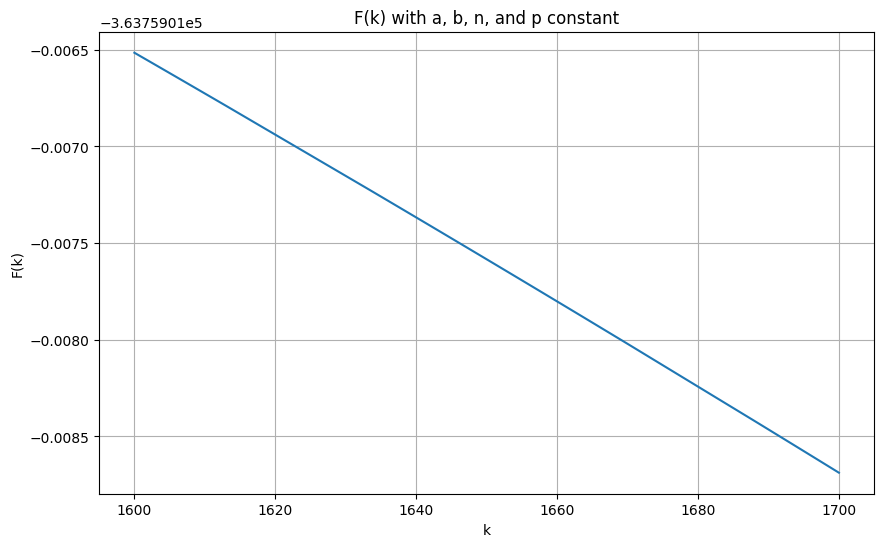

In [185]:
plt.figure(figsize=(10, 6))  # Set figure size for better visibility
plt.plot(k_array, f_k_array)
plt.xlabel('k')
plt.ylabel('F(k)')
plt.title('F(k) with a, b, n, and p constant')
plt.grid(True)  # Add grid for better readability
plt.show()

In [186]:
balancesForPrices = computeBalancesForPrices(A, D, aO, bO, nO, p)
print('balancesForPrices', balancesForPrices)

---- k ---- 378357.8660371058
T 363740.1075460341
dTdk -349689.7796862584
PTn 3381954.384999495
dPdk 0.9613731871253379
alpha 363732.00013196043
---- k ---- 378358.3861268091
T 242493.30587057458
dTdk -155417.93407584084
PTn 2254636.0013426836
dPdk 0.6409169580010325
alpha 363732.00013196043
---- k ---- 378359.166259596
T 161662.1167068459
dTdk -69074.81705892512
PTn 1503090.5233621793
dPdk 0.42727950350732574
alpha 363732.00013196043
---- k ---- 378360.3364543873
T 107774.67518688068
dTdk -30700.048698333532
PTn 1002060.3713262632
dPdk 0.28485458120918455
alpha 363732.00013196043
---- k ---- 378362.09173531213
T 71849.74106241169
dTdk -13644.562971346653
PTn 668040.5199426669
dPdk 0.18990470407029345
alpha 363732.00013196043
---- k ---- 378364.7246266796
T 47899.82531385573
dTdk -6064.325011578118
PTn 445360.99399159214
dPdk 0.1266048925705744
alpha 363732.00013196043
---- k ---- 378368.6738803916
T 31933.275315709554
dTdk -2695.3156421343147
PTn 296908.5391409466
dPdk 0.0844051781247

In [187]:
def compute_invariant(A, balances):
    # Calculate the sum of balances
    total_balance = sum(balances)
    n = len(balances)
    prodBalances = 1
    for i in range(n):
        prodBalances = prodBalances * balances[i]

    # Initial invariant
    D = total_balance

    # Iteratively compute the invariant
    for i in range(500):
        fD = math.pow(D, n+1)/(math.pow(n, n)*prodBalances) + A*math.pow(n, n)*D - D - A*math.pow(n, n)*total_balance
        flD = (n+1)*math.pow(D, n)/(math.pow(n, n)*prodBalances) + A*math.pow(n, n) - 1
        newD = D - fD/flD

        # Check for convergence
        if abs(newD - D) < math.pow(10, -5):
            return newD
        D = newD

    raise RuntimeError("StableInvariantDidntConverge()")

In [190]:
def computeBalance(A, balances, D, tokenIndex):
    x = balances[tokenIndex]
    n = len(balances)
    nn = math.pow(n, n)
    prodBalances = 1
    sumBalances = 0
    for i in range(len(balances)):
        if (i != tokenIndex):
            prodBalances = prodBalances * balances[i]
            sumBalances += balances[i]
        
    for i in range(255):
        fx = A*nn*(sumBalances+x) + D - A*nn*D - math.pow(D, n+1)/(nn*prodBalances*x)
        flx = A*nn + math.pow(D, n+1)/(nn*prodBalances*math.pow(x,2))
        newX = x - fx/flx
        if (abs(x - newX) < math.pow(10, -15)):
            return newX
        x = newX
    raise RuntimeError("StableInvariantDidntConverge()")

def computeOutGivenIn(A, balances, D, tokenInIndex, tokenOutIndex, amountIn):
    newBalances = balances.copy()
    newBalances[tokenInIndex] = newBalances[tokenInIndex] + amountIn
    newBalances[tokenOutIndex] = computeBalance(A, newBalances, D, tokenOutIndex)
    return balances[tokenOutIndex] - newBalances[tokenOutIndex]

In [191]:
newD = compute_invariant(A, balancesForPrices)
print('old invariant', D)
print('new invariant', newD)
tvl = 0
for i in range(len(p)):
    tvl += p[i]*balancesForPrices[i]

print('TVL', tvl)

amountIn = 0.00001
pBase = p[0]
pFinal = np.zeros_like(p)
pFinal[0] = pBase
for i in range(len(p) - 1):
    amountOut = computeOutGivenIn(A, balancesForPrices, D, 0, i+1, amountIn)
    pFinal[i+1] = pBase * amountIn/amountOut

print('final prices', pFinal)


old invariant 11018290.034907777
new invariant 11018290.034907779
TVL 10699496.788274113
final prices [0.96137819 9.89686458]
